In [1]:
import pandas as pd
import numpy as np
import random
import copy
import torch

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 42

In [3]:
data = pd.read_csv('../../GeneralData/ETTh2.csv')
data

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,41.130001,12.481,36.535999,9.355,4.424,1.311,38.661999
1,2016-07-01 01:00:00,37.528000,10.136,33.936001,7.532,4.435,1.215,37.124001
2,2016-07-01 02:00:00,37.946999,11.309,35.330002,9.007,2.100,0.000,36.465000
3,2016-07-01 03:00:00,38.952000,11.895,35.543999,9.436,3.380,1.215,33.608501
4,2016-07-01 04:00:00,38.113998,11.476,35.410000,9.623,2.036,0.000,31.850500
...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,39.202999,11.392,49.644001,11.929,-10.331,-1.258,47.084999
17416,2018-06-26 16:00:00,38.113998,10.974,48.759998,11.366,-10.331,-1.290,48.183498
17417,2018-06-26 17:00:00,39.622002,10.974,50.609001,11.661,-11.557,-1.418,48.183498
17418,2018-06-26 18:00:00,43.643002,13.403,54.737000,13.778,-10.299,-1.418,46.865501


In [4]:
import torch.nn as nn

In [5]:
feature_size = 7

In [6]:
# LSTM은 Encoder와 Decoder를 각각 구현해야 한다.
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_size = 14
        self.input_size = feature_size
        self.encoder = nn.LSTM(input_size = self.input_size,
                       hidden_size = self.hidden_size,
                       num_layers = 1,
                       batch_first = True).to(device)
        # batch_first = True로 인해서 (batch,seq,feature)순으로 입력 받는다.
        # 그 당시에 알고 있는 정보가 없으므로 input_size = 0
        self.decoder = nn.LSTM(input_size = self.input_size,
                       hidden_size = self.hidden_size,
                       num_layers = 1,
                       batch_first = True).to(device)
        
        
        self.output_layer = nn.Linear(self.hidden_size, 1).to(device)
    def forward(self,x):
        x = x.to(device)
        self.encoder.flatten_parameters()
        self.decoder.flatten_parameters()
        outputs,(hidden,cell) = self.encoder(x)
        
        # 현재 prediction_length = 1이기 때문에, 반복문을 돌리지 않아도 됨
        # but 길어진다면 반복문을 돌려서 output값을 얻어야 한다.
        # 기본적으로 output = hidden state이기에 output을 생성할
        # Fully Connected Layer가 필요하게 된다.
        # 이때 decoder_output의 사이즈는 (batch,seq,hidden) 이다
        # 중간에 seq가 들어오게 되는 이유는 입력 크기 만큼 lstm이 반복되기 때문에
        # seq=1 이기 때문에 squeeze를 수행
        
        hidden = hidden.to(device)
        cell = cell.to(device)
        decoder_input = torch.zeros([x.size(0),1,x.size(2)]).to(device)
        decoder_out,(hidden,cell) = self.decoder(decoder_input,(hidden,cell))
        decoder_out = decoder_out.squeeze(1)
        
        out = self.output_layer(decoder_out)
        
        return out

In [7]:
a = np.array([1,2,3])
a.shape[0]

3

In [8]:
lst = [i for i in range(1,13)]
A = torch.FloatTensor(lst).view(3,2,2)
B = torch.zeros((2,2))
B[0,0] = 1
B[1,1] = 1
A*B # BroadCasting

tensor([[[ 1.,  0.],
         [ 0.,  4.]],

        [[ 5.,  0.],
         [ 0.,  8.]],

        [[ 9.,  0.],
         [ 0., 12.]]])

In [9]:
class Filter(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = LSTM()
    def forward(self,x,train_index_matrix=[]):
        # 2차원 인덱스 리스트가 들어온다.
        # train_index_matrix = 2차원
        # 행은 time 열은 Feature를 의미
        if len(train_index_matrix)==0:
            return self.model(x)
        filters = torch.FloatTensor(np.zeros((x.shape[1],x.shape[2])))
        filters = filters.to(device)
        for i in range(len(train_index_matrix)): # len(train_index) = 7
            for train_idx in train_index_matrix[i]:
                filters[train_idx,i] = 1
        x = x*filters
        out = self.model(x)
        return out

In [10]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch

In [11]:
device = torch.device("cuda:0")

In [12]:
sequence_length = 168 # 24*7 1주일
pred_length = 1 # 1시간
split = int(len(data)*0.8)

In [13]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(0,len(x)-sequence_length):
        # 시간데이터를 제외하고 추출
        seq_list.append(x.iloc[i:i+sequence_length,1:].values)
        # OT만 추출
        target_list.append(x.iloc[i+sequence_length,-1])
        
    return torch.FloatTensor(seq_list).view(-1,sequence_length,7).to(device), torch.FloatTensor(target_list).view(-1,pred_len,1).to(device)

In [14]:
train = data.iloc[:split]
val = data.iloc[split:]

X_train, y_train = seq_data(train,sequence_length,pred_length)
X_val, y_val = seq_data(val,sequence_length,pred_length)

tr_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val,y_val)

training =  DataLoader(tr_dataset,batch_size = 64)
validation = DataLoader(val_dataset,batch_size = 64)

/tmp/ipykernel_1390042/2507691695.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return torch.FloatTensor(seq_list).view(-1,sequence_length,7).to(device), torch.FloatTensor(target_list).view(-1,pred_len,1).to(device)


In [15]:
torch.cuda.is_available()

True

In [16]:
X_train.size() # 168개의 sequence_length 7개의 Feature

torch.Size([13768, 168, 7])

* 잘 데이터가 구성된 걸 확인 가능

In [17]:
train.iloc[:169]

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,41.130001,12.481,36.535999,9.355,4.424,1.311,38.661999
1,2016-07-01 01:00:00,37.528000,10.136,33.936001,7.532,4.435,1.215,37.124001
2,2016-07-01 02:00:00,37.946999,11.309,35.330002,9.007,2.100,0.000,36.465000
3,2016-07-01 03:00:00,38.952000,11.895,35.543999,9.436,3.380,1.215,33.608501
4,2016-07-01 04:00:00,38.113998,11.476,35.410000,9.623,2.036,0.000,31.850500
...,...,...,...,...,...,...,...,...
164,2016-07-07 20:00:00,46.155998,12.900,42.112000,10.079,3.497,0.000,41.299000
165,2016-07-07 21:00:00,50.008999,14.659,45.865002,11.205,3.753,1.237,40.200500
166,2016-07-07 22:00:00,46.826000,14.743,44.417000,12.223,2.580,0.000,39.321499
167,2016-07-07 23:00:00,45.235001,13.905,43.022999,11.714,2.665,0.000,38.881500


In [18]:
X_train

tensor([[[41.1300, 12.4810, 36.5360,  ...,  4.4240,  1.3110, 38.6620],
         [37.5280, 10.1360, 33.9360,  ...,  4.4350,  1.2150, 37.1240],
         [37.9470, 11.3090, 35.3300,  ...,  2.1000,  0.0000, 36.4650],
         ...,
         [50.0090, 14.6590, 45.8650,  ...,  3.7530,  1.2370, 40.2005],
         [46.8260, 14.7430, 44.4170,  ...,  2.5800,  0.0000, 39.3215],
         [45.2350, 13.9050, 43.0230,  ...,  2.6650,  0.0000, 38.8815]],

        [[37.5280, 10.1360, 33.9360,  ...,  4.4350,  1.2150, 37.1240],
         [37.9470, 11.3090, 35.3300,  ...,  2.1000,  0.0000, 36.4650],
         [38.9520, 11.8950, 35.5440,  ...,  3.3800,  1.2150, 33.6085],
         ...,
         [46.8260, 14.7430, 44.4170,  ...,  2.5800,  0.0000, 39.3215],
         [45.2350, 13.9050, 43.0230,  ...,  2.6650,  0.0000, 38.8815],
         [44.7320, 13.9050, 42.4340,  ...,  1.3110,  0.0000, 38.2230]],

        [[37.9470, 11.3090, 35.3300,  ...,  2.1000,  0.0000, 36.4650],
         [38.9520, 11.8950, 35.5440,  ...,  3

In [19]:
y_train

tensor([[[38.2230]],

        [[38.0030]],

        [[37.5635]],

        ...,

        [[15.5910]],

        [[15.8105]],

        [[15.1515]]], device='cuda:0')

In [20]:
from torch.optim import Adam

In [21]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
model = Filter().to(device)
optimizer = Adam(model.parameters(),lr = 1e-4)
num_epochs = 200
n = len(training)

In [22]:
def MSE(pred,target):
    return torch.mean((pred-target)**2,dim = 0) # reduction까지 취해줌

In [23]:
model.named_parameters

<bound method Module.named_parameters of Filter(
  (model): LSTM(
    (encoder): LSTM(7, 14, batch_first=True)
    (decoder): LSTM(7, 14, batch_first=True)
    (output_layer): Linear(in_features=14, out_features=1, bias=True)
  )
)>

In [24]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
minimal_loss=np.inf
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
#         print(outputs.size())
        outputs = outputs.view(-1,1)    
        labels = labels.view(-1,1)
        
        # defining loss
        loss = MSE(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)))
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model

Epoch [1]/[200] running accumulative loss across all batches: 869.021
changed
Epoch [2]/[200] running accumulative loss across all batches: 859.793
changed
Epoch [3]/[200] running accumulative loss across all batches: 846.626
changed
Epoch [4]/[200] running accumulative loss across all batches: 829.433
changed
Epoch [5]/[200] running accumulative loss across all batches: 809.352
changed
Epoch [6]/[200] running accumulative loss across all batches: 783.139
changed
Epoch [7]/[200] running accumulative loss across all batches: 761.134
changed
Epoch [8]/[200] running accumulative loss across all batches: 740.211
changed
Epoch [9]/[200] running accumulative loss across all batches: 720.916
changed
Epoch [10]/[200] running accumulative loss across all batches: 704.162
changed
Epoch [11]/[200] running accumulative loss across all batches: 688.206
changed
Epoch [12]/[200] running accumulative loss across all batches: 671.672
changed
Epoch [13]/[200] running accumulative loss across all batches

Epoch [105]/[200] running accumulative loss across all batches: 91.972
changed
Epoch [106]/[200] running accumulative loss across all batches: 89.842
changed
Epoch [107]/[200] running accumulative loss across all batches: 87.755
changed
Epoch [108]/[200] running accumulative loss across all batches: 85.712
changed
Epoch [109]/[200] running accumulative loss across all batches: 83.709
changed
Epoch [110]/[200] running accumulative loss across all batches: 81.746
changed
Epoch [111]/[200] running accumulative loss across all batches: 79.820
changed
Epoch [112]/[200] running accumulative loss across all batches: 77.936
changed
Epoch [113]/[200] running accumulative loss across all batches: 76.092
changed
Epoch [114]/[200] running accumulative loss across all batches: 74.291
changed
Epoch [115]/[200] running accumulative loss across all batches: 72.519
changed
Epoch [116]/[200] running accumulative loss across all batches: 70.785
changed
Epoch [117]/[200] running accumulative loss across a

In [25]:
from captum.attr import IntegratedGradients,NoiseTunnel

In [26]:
for val_batch in validation:
    temp_n = val_batch[0].size(0)
    for val in val_batch[0]: # 하나의 배치에 대해서 for문
        val = val.unsqueeze(0) # 
        break
val.size()

torch.Size([1, 168, 7])

## basis와 함수값 그리고 Attribution비교

In [27]:
ig = IntegratedGradients(model)
temp = ig.attribute(val)

In [28]:
temp.sum()

tensor(39.5324, device='cuda:0', dtype=torch.float64)

In [29]:
basis = torch.FloatTensor(np.zeros((1,168,7)))
model(basis)

tensor([[-1.1632]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [30]:
model(val)

tensor([[38.3692]], device='cuda:0', grad_fn=<AddmmBackward0>)

### 위의 두값을 더하면 temp.sum() 이 나온다

In [31]:
temp.size()

torch.Size([1, 168, 7])

In [32]:
temp = temp.squeeze(0)

In [33]:
temp.sum()/(168*7) == temp.sum(axis = 1)[0].sum(axis = 0).item() # 3차원에선 맞았지만 2차원에선 안맞음 걍 sum()쓰자

tensor(False, device='cuda:0')

### Uniform한 기준을 세운다

In [34]:
cnt = 0
ig = IntegratedGradients(model)
ig_attr_score = np.zeros((sequence_length,feature_size))

uniform_dist = []
for val_batch in validation:
    temp_n = val_batch[0].size(0)
    for val in val_batch[0]: # 하나의 배치에 대해서 for문
        val = val.unsqueeze(0) # size = [1,168,7] 원래 LSTM은 Batch형태로 들어가야 한다.
        # ig로 각 Validation Sample 1개의 영향을 구한다.
        temp = ig.attribute(val)
        temp = temp.squeeze(0)
        
        uniform_line = temp.sum().item() # 전체 행 과 열에 대해서 sum
        uniform_dist.append(uniform_line)
        
        temp = temp.abs()# 2차원
        temp = temp.to("cpu").detach().numpy()   
        ig_attr_score = ig_attr_score+temp
    cnt = cnt + temp_n
ig_attr_score = ig_attr_score/cnt

In [35]:
uniform_result = 0
for elem in uniform_dist:
    uniform_result=uniform_result+elem
uniform_result = uniform_result/(cnt*sequence_length*feature_size)
uniform_result

0.02375264707109408

In [36]:
ig_attr_score[ig_attr_score<uniform_result].shape

(1094,)

In [37]:
ig_attr_score.mean()

0.05922315506972992

In [38]:
ig_attr_score.min()

3.844757125971151e-06

In [39]:
ig_attr_score.min()

3.844757125971151e-06

### Feature Attribution DF를 쪼개는 코드

In [40]:
sub_attr_df = []
for cnt,column in enumerate(list(data.columns[1:])):
    attr_df = pd.DataFrame(ig_attr_score[:,cnt],columns = [column]) # 잘못 수행함
    sub_attr_df.append(attr_df)
sub_attr_df

[         HUFL
 0    0.000026
 1    0.000017
 2    0.000017
 3    0.000019
 4    0.000019
 ..        ...
 163  0.096614
 164  0.308161
 165  0.959245
 166  1.954634
 167  8.199329
 
 [168 rows x 1 columns],
          HULL
 0    0.000036
 1    0.000042
 2    0.000042
 3    0.000041
 4    0.000040
 ..        ...
 163  0.031408
 164  0.062136
 165  0.239500
 166  0.894450
 167  0.594686
 
 [168 rows x 1 columns],
          MUFL
 0    0.000185
 1    0.000217
 2    0.000222
 3    0.000220
 4    0.000221
 ..        ...
 163  0.405879
 164  0.475932
 165  1.320554
 166  3.717501
 167  3.590749
 
 [168 rows x 1 columns],
          MULL
 0    0.000052
 1    0.000053
 2    0.000053
 3    0.000053
 4    0.000052
 ..        ...
 163  0.038112
 164  0.062596
 165  0.338587
 166  0.795694
 167  2.614814
 
 [168 rows x 1 columns],
          LUFL
 0    0.000054
 1    0.000064
 2    0.000064
 3    0.000062
 4    0.000062
 ..        ...
 163  0.060272
 164  0.173404
 165  0.286344
 166  1.013942
 167  1

### 이상치를 제거하는 구간(Uniform Distribution 사용)

* outlier(최근에 생긴값)이 평균을 지배해서 outlier 이전의 값들은 Noise 처리가 되는 것을 볼 수 있다.
    * ex>151개인데 150번까지 Noise

In [41]:
for attr_df in sub_attr_df:
    print(attr_df[attr_df.iloc[:,0]<uniform_result])

         HUFL
0    0.000026
1    0.000017
2    0.000017
3    0.000019
4    0.000019
..        ...
157  0.019156
158  0.020470
159  0.021177
160  0.021720
161  0.023307

[162 rows x 1 columns]
         HULL
0    0.000036
1    0.000042
2    0.000042
3    0.000041
4    0.000040
..        ...
156  0.011390
157  0.013026
158  0.015009
159  0.017398
160  0.020270

[161 rows x 1 columns]
         MUFL
0    0.000185
1    0.000217
2    0.000222
3    0.000220
4    0.000221
..        ...
137  0.017300
138  0.018469
139  0.019783
140  0.021170
141  0.022606

[142 rows x 1 columns]
         MULL
0    0.000052
1    0.000053
2    0.000053
3    0.000053
4    0.000052
..        ...
157  0.013116
158  0.015087
159  0.017474
160  0.021091
161  0.023289

[162 rows x 1 columns]
         LUFL
0    0.000054
1    0.000064
2    0.000064
3    0.000062
4    0.000062
..        ...
154  0.015856
155  0.017296
156  0.018842
157  0.020492
158  0.022269

[159 rows x 1 columns]
         LULL
0    0.000004
1    0.00000

In [42]:
candidate_sub_attr_df = []
for attr_df in sub_attr_df:
    candidate_sub_attr_df.append(attr_df[attr_df.iloc[:,0]<uniform_result])
candidate_sub_attr_df

[         HUFL
 0    0.000026
 1    0.000017
 2    0.000017
 3    0.000019
 4    0.000019
 ..        ...
 157  0.019156
 158  0.020470
 159  0.021177
 160  0.021720
 161  0.023307
 
 [162 rows x 1 columns],
          HULL
 0    0.000036
 1    0.000042
 2    0.000042
 3    0.000041
 4    0.000040
 ..        ...
 156  0.011390
 157  0.013026
 158  0.015009
 159  0.017398
 160  0.020270
 
 [161 rows x 1 columns],
          MUFL
 0    0.000185
 1    0.000217
 2    0.000222
 3    0.000220
 4    0.000221
 ..        ...
 137  0.017300
 138  0.018469
 139  0.019783
 140  0.021170
 141  0.022606
 
 [142 rows x 1 columns],
          MULL
 0    0.000052
 1    0.000053
 2    0.000053
 3    0.000053
 4    0.000052
 ..        ...
 157  0.013116
 158  0.015087
 159  0.017474
 160  0.021091
 161  0.023289
 
 [162 rows x 1 columns],
          LUFL
 0    0.000054
 1    0.000064
 2    0.000064
 3    0.000062
 4    0.000062
 ..        ...
 154  0.015856
 155  0.017296
 156  0.018842
 157  0.020492
 158  0

In [43]:
import matplotlib.pyplot as plt

[         attr
 0    0.000405
 1    0.000000
 2    0.000032
 3    0.000092
 4    0.000123
 ..        ...
 157  0.821761
 158  0.878167
 159  0.908560
 160  0.931849
 161  1.000000
 
 [162 rows x 1 columns],
          attr
 0    0.000000
 1    0.000338
 2    0.000329
 3    0.000261
 4    0.000234
 ..        ...
 156  0.561179
 157  0.642002
 158  0.740038
 159  0.858092
 160  1.000000
 
 [161 rows x 1 columns],
          attr
 0    0.000000
 1    0.001432
 2    0.001641
 3    0.001567
 4    0.001617
 ..        ...
 137  0.763370
 138  0.815468
 139  0.874081
 140  0.935971
 141  1.000000
 
 [142 rows x 1 columns],
          attr
 0    0.000000
 1    0.000062
 2    0.000058
 3    0.000045
 4    0.000035
 ..        ...
 157  0.562211
 158  0.647021
 159  0.749744
 160  0.905406
 161  1.000000
 
 [162 rows x 1 columns],
          attr
 0    0.000000
 1    0.000470
 2    0.000467
 3    0.000392
 4    0.000393
 ..        ...
 154  0.711340
 155  0.776156
 156  0.845753
 157  0.919987
 158  1

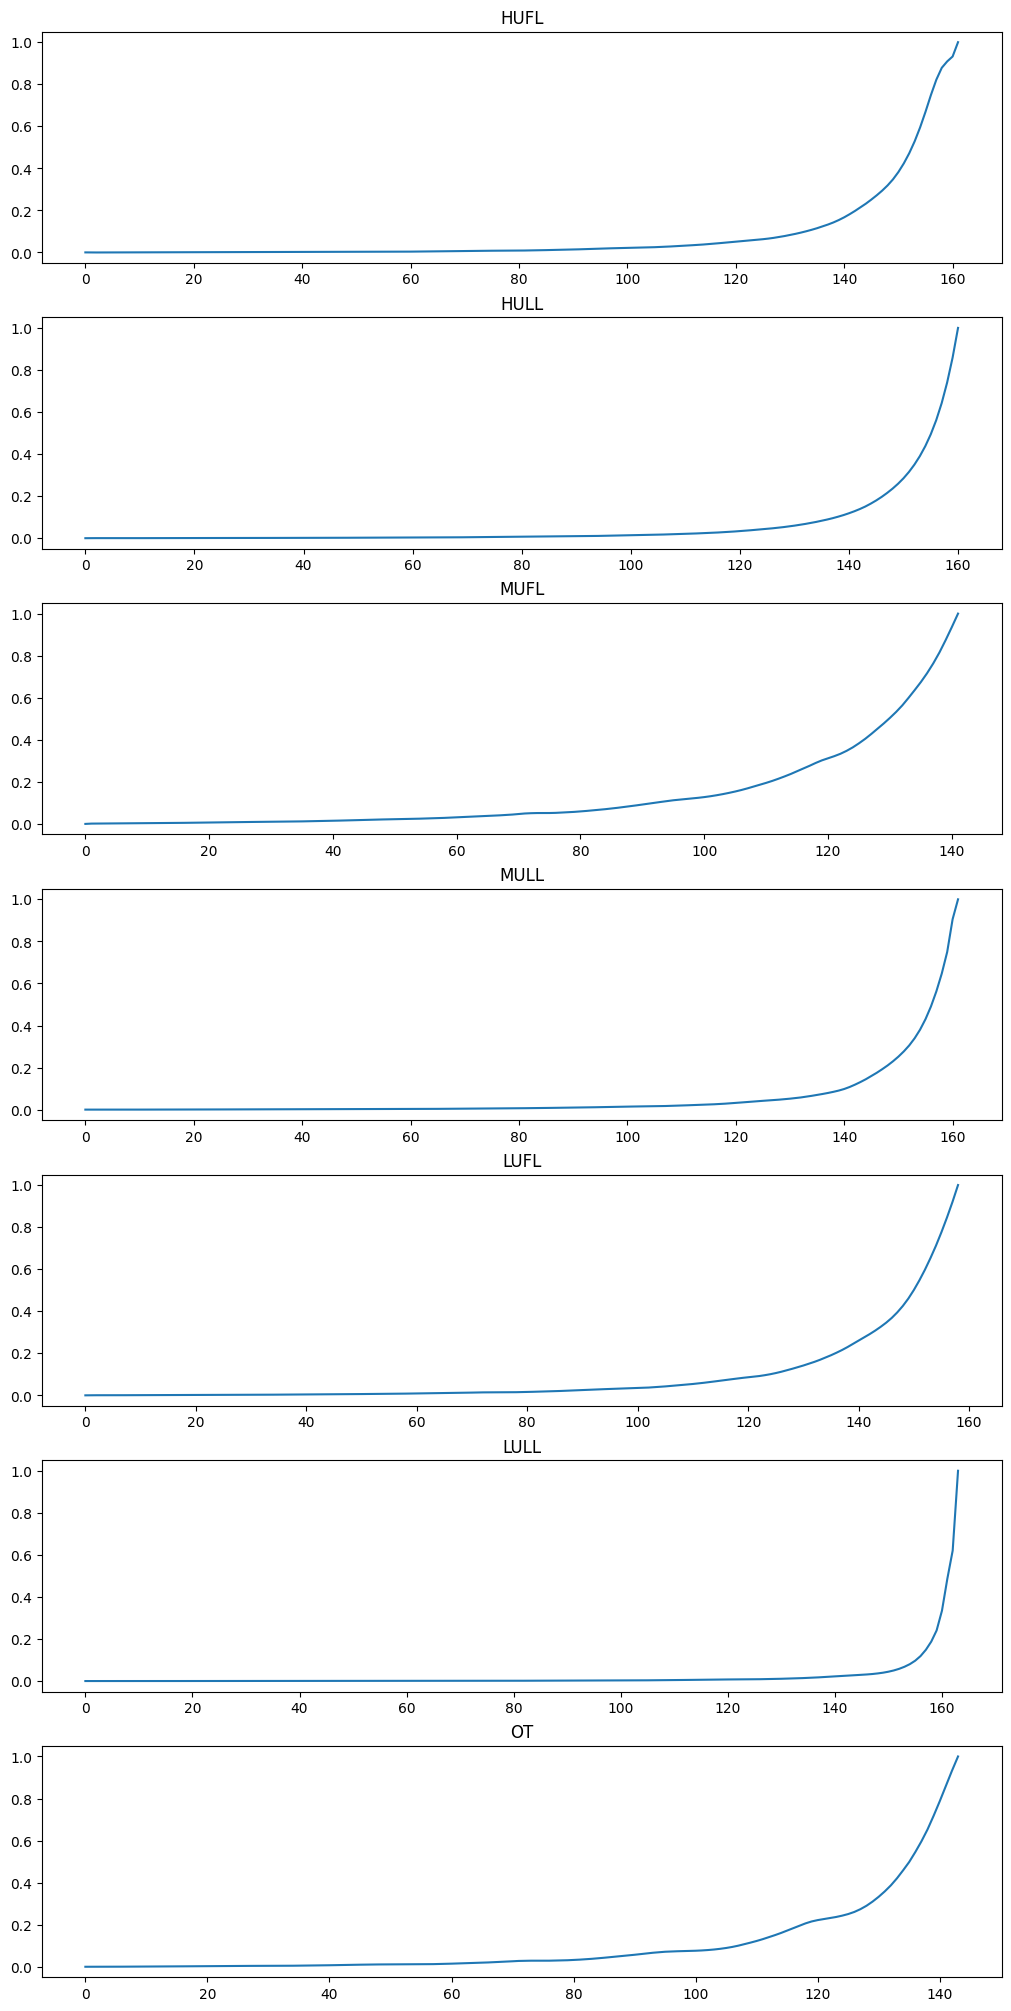

In [44]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
filtering_attr_list = [] # scaling한 attribution dataframe을 저장
fig,ax = plt.subplots(7,1,figsize = (10,20),constrained_layout=True)
# constrained_layout=True 으로 subplot간의 간격 최적으로 조절
for cnt,candidate_attr in enumerate(candidate_sub_attr_df):
    scaler = MinMaxScaler()
    scaler.fit(candidate_attr.values)
    m_attr_df = scaler.transform(candidate_attr.values)
    m_attr_df = pd.DataFrame({"attr":m_attr_df.reshape(-1)})
    filtering_attr_list.append(m_attr_df)
    ax[cnt].plot(m_attr_df)
    ax[cnt].set_title(candidate_attr.columns.item())
filtering_attr_list

In [45]:
total_index_list = [] # train할 index를 저장해두는 리스트이다.
for hyper_para in np.arange(0.00,1.00,0.01):
    index_list = []
    # filtering index를 만든다.
    for m_attr_df in filtering_attr_list:
        append_idx = list(m_attr_df[(m_attr_df['attr']>=hyper_para)].index)
        index_list.append(append_idx)
    total_index_list.append(index_list)
len(total_index_list) 

100

In [46]:
from pytorch_forecasting.metrics import SMAPE,MAE,RMSE

In [ ]:
### 원래 난수가 선언된 위치
m = len(validation)
n = len(training)
cnt = 0
num_epochs = 100
mse_out_list = []
mae_out_list = []
smape_out_list = []
rmse_out_list = []
for sub_index_list in total_index_list: #0.01~1.00 100개의 index에 대해서 수행
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
    train_idx = sub_index_list
    minimal_loss=np.inf
    model = Filter().to(device) # 모델 초기화
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer 초기화
    result = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in training:
            # forward pass
            inputs = inputs
            
            outputs = model(inputs,train_idx)
            outputs = outputs.view(-1,1)
            labels = labels.view(-1,1)            
            # defining loss
            loss = MSE(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch == 99:    
            print(f'{cnt}번째 모델 Training 완료 마지막 Epoch loss:{(running_loss/n)*100}')
        
        if (running_loss/n)*100<minimal_loss:
            best_model = copy.deepcopy(model)
            minimal_loss = (running_loss/n)*100
            print("changed")

    model = best_model
    cnt+=1
    # 모델 Fully-Training 완료
    
    pred = torch.FloatTensor().to(device)
    val_target = torch.FloatTensor().to(device)
    for val_x,val_y in validation:
        tmp_pred = model(val_x)
        pred = torch.concat([pred,tmp_pred], dim=0)
        val_target = torch.concat([val_target,val_y],dim = 0)
    pred = pred.view(-1,1)
    val_target = val_target.view(-1,1)
    result = MSE(pred,val_target).item()
    mse_out_list.append(result)
    mae_out_list.append(MAE()(pred,val_target).item())
    rmse_out_list.append(RMSE()(pred,val_target).item())
    smape_out_list.append(SMAPE()(pred,val_target).item()*100)

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed


In [55]:
len(train_idx)

7

In [67]:
print(mse_out_list[0])

print(np.array(mse_out_list).min())

print(mae_out_list[0])

print(np.array(mae_out_list).min())

print(rmse_out_list[0])

print(np.array(rmse_out_list).min())

print(smape_out_list[0])

print(np.array(smape_out_list).min())

470.3684387207031
131.29464721679688
18.6782169342041
9.748717308044434
21.687978744506836
11.45838737487793
94.34552192687988
39.36178684234619


In [56]:
train_idx[0] # time step 0

[161]

In [65]:
mse_out_list[0]

470.3684387207031

In [57]:
len(mse_out_list)

100

In [63]:
np.array(mse_out_list).min()

131.29464721679688

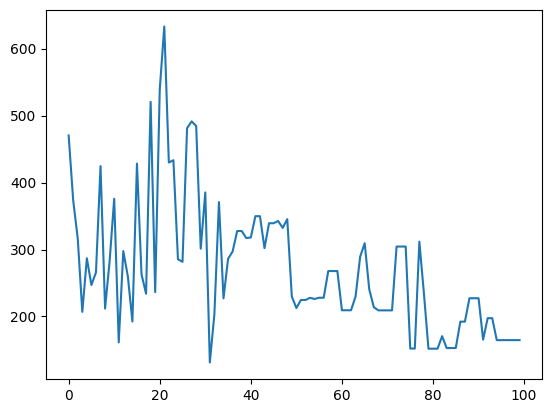

In [62]:
plt.plot(mse_out_list)

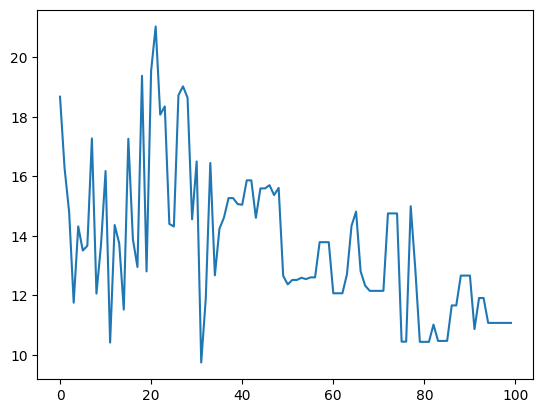

In [59]:
plt.plot(mae_out_list)

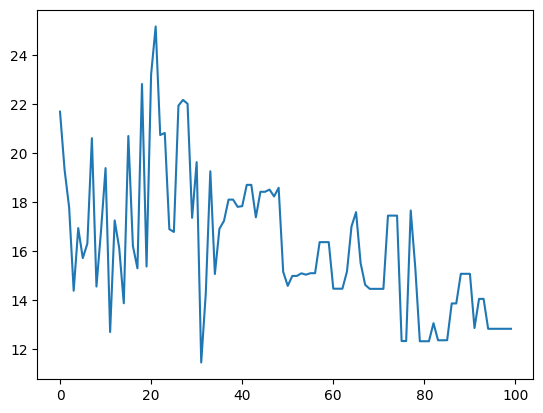

In [60]:
plt.plot(rmse_out_list)

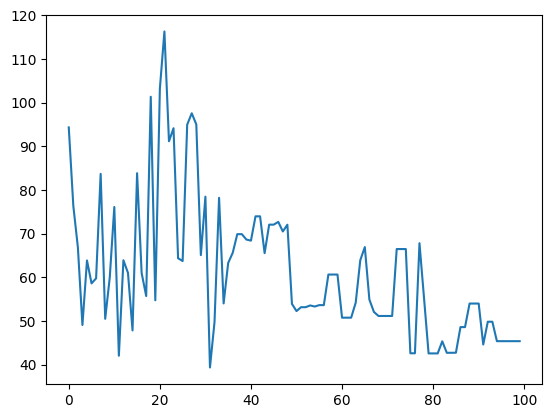

In [61]:
plt.plot(smape_out_list)